**Emotion Detection**

**Importing Libraries**

In [7]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf 

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


**Exploring Dataset**

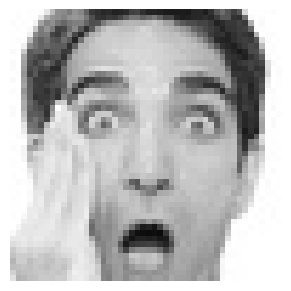

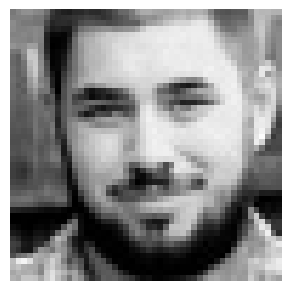

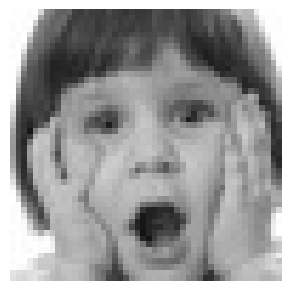

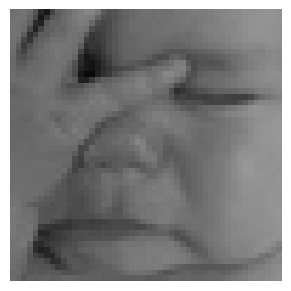

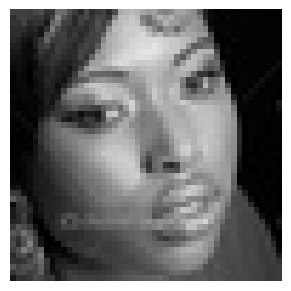

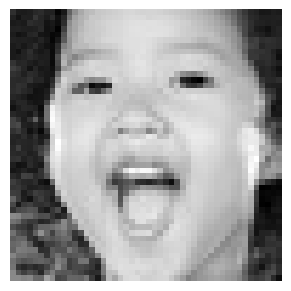

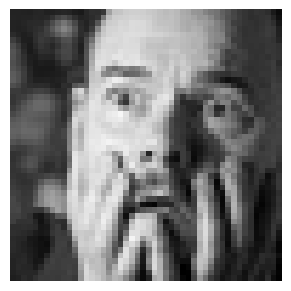

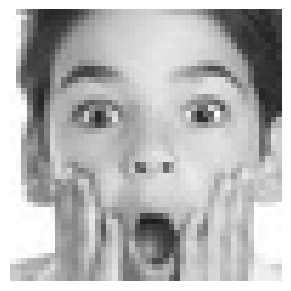

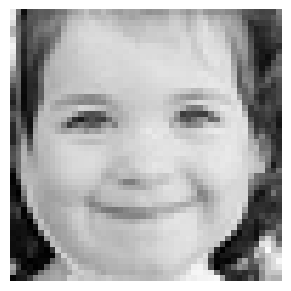

In [8]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331*1)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Trainig**


In [9]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
                                                    


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [10]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2,))(x)
    x = Dropout(0.25)(x)

    return x



In [11]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x


In [12]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])

    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model                                                                                                                 

In [13]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initializing the Model**

In [14]:
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]


**Training the Model**

**The next call takes time to complete**

In [15]:
history = model.fit(
    x = train_generator, 
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


C:\Users\Yelgonda Bhargavi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.3312 - loss: 1.7951
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 440s 969ms/step - accuracy: 0.3313 - loss: 1.7947 - val_accuracy: 0.3648 - val_loss: 1.6154
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:06 418ms/step - accuracy: 0.4531 - loss: 1.5684
Epoch 2: saving model to model_weights.weights.h5


C:\Users\Yelgonda Bhargavi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4531 - loss: 1.5684 - val_accuracy: 0.4000 - val_loss: 1.4878
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4962 - loss: 1.3452
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 243s 540ms/step - accuracy: 0.4962 - loss: 1.3452 - val_accuracy: 0.4562 - val_loss: 1.4231
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:47 376ms/step - accuracy: 0.5625 - loss: 1.3060
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.3060 - val_accuracy: 0.6000 - val_loss: 1.2896
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.5707 - loss: 1.1602
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 187s 418ms/step - accuracy: 0.5707 - loss: 1.1602 - val_accuracy: 0.4347 - val_loss: 1.4581
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:56 394ms/step - accuracy: 0.3750 - loss: 1.3703
Epoch 6: saving mo

**Model Evaluation**

In [16]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - accuracy: 0.4315 - loss: 1.7812


[1.741737961769104, 0.4414878785610199]

**Plotting Loss**

Tensorflow version: 2.16.1
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/15


C:\Users\Yelgonda Bhargavi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3332 - loss: 1.8465
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step - accuracy: 0.3333 - loss: 1.8461 - val_accuracy: 0.3061 - val_loss: 1.8422
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:56 394ms/step - accuracy: 0.4375 - loss: 1.5705
Epoch 2: saving model to model_weights.weights.h5


C:\Users\Yelgonda Bhargavi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.5705 - val_accuracy: 0.3000 - val_loss: 1.9551
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4890 - loss: 1.3487
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 261s 582ms/step - accuracy: 0.4890 - loss: 1.3487 - val_accuracy: 0.3527 - val_loss: 1.5962
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:57 398ms/step - accuracy: 0.3906 - loss: 1.4932
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3906 - loss: 1.4932 - val_accuracy: 0.3000 - val_loss: 1.9838
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5650 - loss: 1.1697
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1025s 2s/step - accuracy: 0.5650 - loss: 1.1697 - val_accuracy: 0.4498 - val_loss: 1.4599
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:58 400ms/step - accuracy: 0.5625 - loss: 1.2220
Epoch 6: saving model t

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplot_adjust'

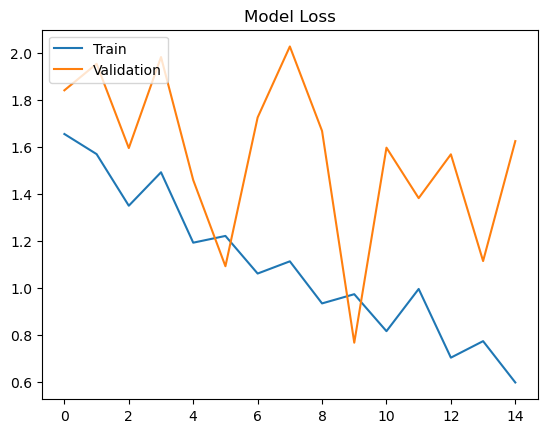

In [11]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf 

print("Tensorflow version:", tf.__version__)

img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2,))(x)
    x = Dropout(0.25)(x)

    return x

def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

    
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])

    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model                              
    
model = model_fer((48,48,1))
model.summary()

img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]


history = model.fit(
    x = train_generator, 
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplot_adjust(top=1.0,bottom=0.0,right = 0.95,left=0.0,hspace=0.25,wspace=0.35)

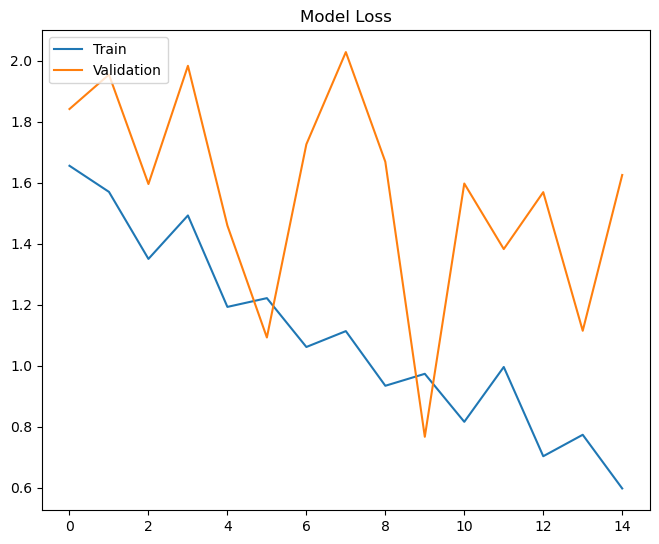

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right = 0.95,left=0.0,hspace=0.25,wspace=0.35)

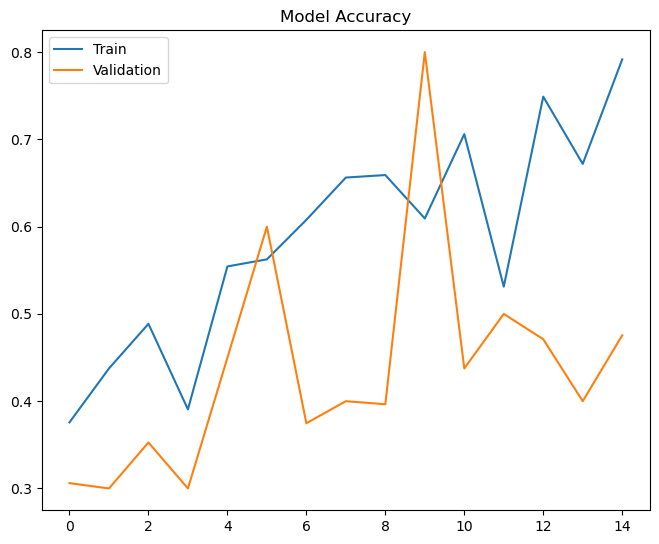

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right = 0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**

In [18]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)